In [1]:
#import models
import numpy as np
import h5py
import sys, os
import rospy
import rosbag
import math
from scipy.interpolate import interp1d
import h5py
import matplotlib.pylab as plt
import time 
import cv2 

#sys.path.insert(0, '/media/abdulla/Seagate Expansion Drive/DVS research/DATA/contact estimation/')
from EventPreProcess import EventPreProcess
#from dvs_msgs.msg import EventArray
from std_msgs.msg import Float64, Bool
from geometry_msgs.msg import Pose, Vector3, PoseStamped

In [2]:
#parameters of processing
frequency = 30 #Hz
bag_file_name = 'tactile_sensing_data/dataset_1.bag'
h5_file_name = 'dataset_1_new.hdf5'
time_window_size = 6
examples_per_edge = 1

In [3]:
bag_file = rosbag.Bag(bag_file_name)

events = []
contact_status = []
contact_status_ts = []
contact_case = [] #0:No contact 1: center, 2:remainder of contacts as in list_of_rotations
contact_case_ts = []

contact_case_updated = []
contact_case_updated_ts = []


#generate labels
possible_angle = [0.075, 0.15]#[0.0174532925, 0.034906585, 0.0523598776, 0.075, 0.095, 0.115, 0.135, 0.15]#
N_examples = 9
list_of_rotations = [[0, 0, 0]]

for i in range(1, N_examples):
    theta = i * 2 * math.pi/(N_examples - 1)
    for phi in possible_angle:
        rx = phi * math.cos(theta)
        ry = phi * math.sin(theta)
        rotvec = [rx, ry, 0]
        list_of_rotations.append(rotvec)

print(len(list_of_rotations))
print(list_of_rotations)


17
[[0, 0, 0], [0.053033008588991064, 0.053033008588991064, 0], [0.10606601717798213, 0.10606601717798213, 0], [4.592425496802574e-18, 0.075, 0], [9.184850993605149e-18, 0.15, 0], [-0.05303300858899106, 0.053033008588991064, 0], [-0.10606601717798211, 0.10606601717798213, 0], [-0.075, 9.184850993605149e-18, 0], [-0.15, 1.8369701987210297e-17, 0], [-0.05303300858899108, -0.05303300858899106, 0], [-0.10606601717798216, -0.10606601717798211, 0], [-1.3777276490407722e-17, -0.075, 0], [-2.7554552980815445e-17, -0.15, 0], [0.05303300858899105, -0.05303300858899108, 0], [0.1060660171779821, -0.10606601717798216, 0], [0.075, -1.8369701987210297e-17, 0], [0.15, -3.6739403974420595e-17, 0]]


In [4]:
# def filter_events_by_time(events, time_of_contact):
#         time_period = 0.3 #sec
#         end_remove_idx = 0
#         end_time = events[-1][2]#time_of_contact + time_period # time of the last event in the list
#         # print("end_time: ", end_time)
#         # print("start_time: ", events[0][2])
        
#         for i in range(0, len(events)):
#             # print(end_time - events[i][2])
#             print(end_time - events[i][2] < time_period)
#             if end_time - events[i][2] < time_period:
#                 break            
#             end_remove_idx = i  

#         events = events[end_remove_idx:]
#         #print("length: ", len(events))
#         return events

In [4]:
def filter_events_by_time(events, time_of_contact, time_period = 0.3e9, threshold=20000):
    event_time = np.array([events[i][2] for i in range(np.shape(events)[0])])
    event_in_time_idx = np.where((event_time > (time_of_contact - time_period)) * (event_time < time_of_contact))[0]
    print(len(event_in_time_idx))
    if len(event_in_time_idx) < threshold:
        return False, []
    else:
        print(event_in_time_idx)
        output_events = np.array(events)[event_in_time_idx,:]
        return True,output_events

In [6]:
# def check_contact(events):
#         contact_threshold = 10000 # no. of events 
#         #print("length: ",len(self.new_events_list))
#         if len(events) > contact_threshold:
#             contact_status = True
#         else:
#             contact_status =  False
        
#         return contact_status

In [5]:
#parse rosbag

for topic, msg, t in bag_file.read_messages(topics=['/contact_status', '/dvs/events', '/contact_angle']):
    if topic == '/dvs/events':
        for e in msg.events:
            event = [e.x, e.y, e.ts.to_nsec(), e.polarity]
            events.append(event)
        event_topic = True    
    elif topic == '/contact_status':
        contact_status.append(msg.data)
        contact_status_ts.append(t.to_nsec())
    elif topic == '/contact_angle':
        if (len(contact_status) > 1):
            if (contact_status[-1] == True):
                best_rot_diff = 100
                best_rot_idx = 1
                i = 1
                for rot in list_of_rotations:
                    diff_vals = np.sqrt( np.power(rot[0] - msg.x, 2) +  np.power(rot[1] - msg.y, 2) + np.power(rot[2] - msg.z, 2) )
                    if best_rot_diff > diff_vals:
                        best_rot_diff = diff_vals
                        best_rot_idx = i
                    i = i + 1

                contact_case.append(best_rot_idx)
                contact_case_ts.append(t.to_nsec())
            else:
                contact_case.append(0)
                contact_case_ts.append(t.to_nsec())
        else:
            contact_case.append(0)
            contact_case_ts.append(t.to_nsec())
        
        # Updated contact status according to no. of events
        
            
#print(events)
bag_file.close()

In [6]:
#interpolate
f = interp1d(contact_case_ts, contact_case, kind='previous')
contact_case_ts_int = range(min(contact_case_ts), max(contact_case_ts), int(1e9/frequency))
contact_case_int = f(contact_case_ts_int)

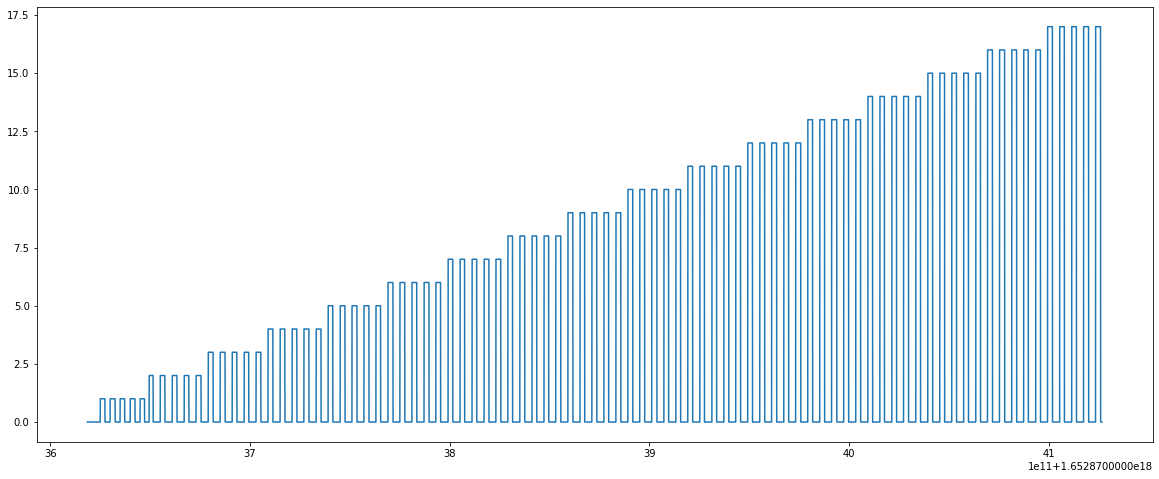

15241


In [7]:
plt.figure(figsize=(20,8))
plt.plot(contact_case_ts_int, contact_case_int)
plt.show()
print(len(contact_case_ts_int))

In [8]:
print((contact_case_ts_int[101] - contact_case_ts_int[100])/1e9)

0.033333333


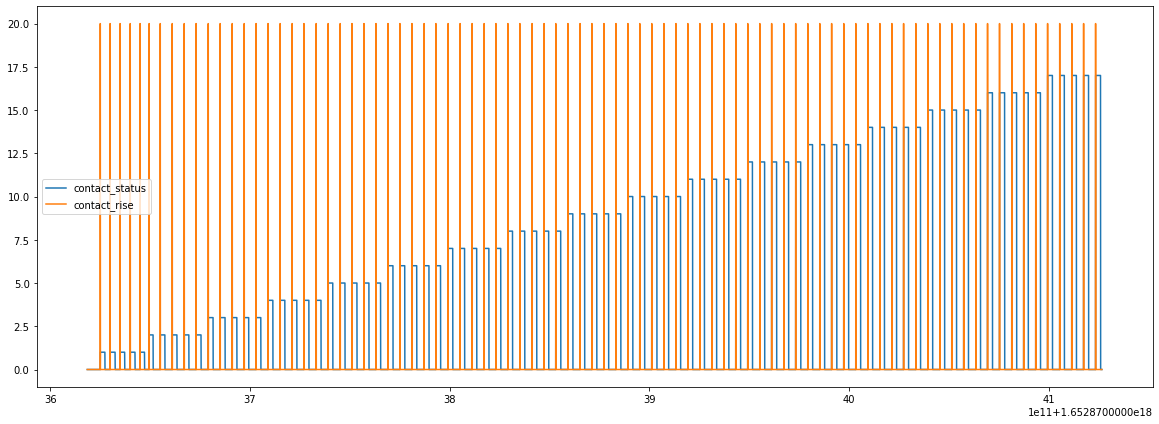

In [9]:
from scipy import signal
#find the rising peak
# contact_peaks_idx, contact_peak_magnitude = signal.find_peaks(contact_case_int, height=0.4, distance=30)
contact_case_diff_int = np.diff(contact_case_int)
contact_case_diff_int = np.insert(contact_case_diff_int, 0, 0)
contact_rise_idx = np.where(contact_case_diff_int > 0.4)[0]

contact_rise_int = [0 for i in range(len(contact_case_int))]
for index in contact_rise_idx:
    contact_rise_int[index] = 20


plt.figure(figsize=(20,7))
plt.plot(contact_case_ts_int, contact_case_int)
plt.plot(contact_case_ts_int, contact_rise_int)
plt.legend(['contact_status', 'contact_rise'])
plt.show()

In [10]:
def generateFrames(event_list, time_steps, im_height=260, im_width=346, im_channel=3, time_window=None):
        event_iterator = 0
        channel = 0
        x = [0, 0, 0]
        event_image = np.zeros((im_height, im_width, im_channel), dtype=np.float32)
        for ts in time_steps:
            
            for i in range(event_iterator, len(event_list)):
                event_iterator = i + 1
                event = np.copy(event_list[i]) #[x, y, ts, polarity]
                if (time_window==None) or (event[2] > ts - time_window):
                    if event[2] > ts:
                        event_image[201, 154, 0] = 0
                        channel = channel + 1
                        #print("cahnnel = ", channel)
                        break
                    else:
                        # print("ha")
                        x[channel] = x[channel] + 1
                        if event[3] > 0:
                            event_image[int(event[1]), int(event[0]), channel] = event_image[int(event[1]), int(event[0]), channel] + 1.0
                        else:
                            event_image[int(event[1]), int(event[0]), channel] = event_image[int(event[1]), int(event[0]), channel] - 1.0             
        
        return event_image

In [11]:
def cropFrames(image, circle_center=(173, 130), circle_rad=100, im_height=260, im_width=346, im_channels=3):
        mask = np.zeros((im_height, im_width, im_channels), dtype=np.float32)            
        cv2.circle(mask, circle_center, circle_rad, [1]*im_channels, -1, 8, 0)
        cropped_image = np.multiply(mask, image)

        return cropped_image

In [12]:

label_contact_case = np.array(contact_case_int)[contact_rise_idx+1]
print(label_contact_case)

[ 1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  3.  3.  3.  3.  3.  4.  4.  4.
  4.  4.  5.  5.  5.  5.  5.  6.  6.  6.  6.  6.  7.  7.  7.  7.  7.  8.
  8.  8.  8.  8.  9.  9.  9.  9.  9. 10. 10. 10. 10. 10. 11. 11. 11. 11.
 11. 12. 12. 12. 12. 12. 13. 13. 13. 13. 13. 14. 14. 14. 14. 14. 15. 15.
 15. 15. 15. 16. 16. 16. 16. 16. 17. 17. 17. 17. 17.]


In [14]:
hf.close()

NameError: name 'hf' is not defined

In [ ]:

# hf = h5py.File("trial.hdf5", 'w')
# ii = 0
# label_contact_case = []
# for i in contact_rise_idx:
#     label_contact_case.append(np.array(contact_case_int)[i+1])
#     print(np.array(contact_case_int)[i+1])
#     print(label_contact_case)
#     if ii == 0:
#         hf.create_dataset('contact_status', data=label_contact_case, maxshape=(None, ))
#     else:
#         hf['contact_status'].resize(len(hf['contact_status']) + len(label_contact_case), axis=0)
#         hf["contact_status"][-len(label_contact_case):] = label_contact_case
#     ii = ii +1
# print(hf['contact_status'].shape)
# hf.close()

# print(len(hf['contact_status']))
# hf['contact_status'].resize(len(hf['contact_status']) + 1, axis=0)
# print(len(hf['contact_status']))
# hf["contact_status"][-len(label_contact_case):] = label_contact_case
# print(len(hf['contact_status']))

In [ ]:
# hf = h5py.File(h5_file_name, 'w')
# #find events that satisfy time
# label_contact_case = []
# i=0
# for status_index in contact_rise_idx:
#     #event_frames_list = []
#     for j in range(-7, 8):
#         time_step = contact_case_ts_int[ status_index + j ]
#         detect, event_array = filter_events_by_time(events, time_step)
#         if detect:
#             frame_time_steps = [time_step-0.2e9, time_step-0.1e9, time_step]
#             event_frame = generateFrames(event_array, frame_time_steps)
#             cropped_image = cropFrames(event_frame)
#             #event_frames_list.append(cropped_image)
#             label_contact_case = np.array(contact_case_int)[status_index+1]
#             if i==0:
#                 hf.create_dataset('contact_status', data=label_contact_case, maxshape=(None,))
#                 hf.create_dataset('event_images', data=cropped_image, maxshape=(None,None, None, None))
#             else:
#                 hf['contact_status'].resize(len(hf['contact_status']) + 1, axis=0)
#                 hf["contact_status"][-1] = label_contact_case
#                 hf['event_images'].resize(len(hf['event_images']) + 1, axis=0)
#                 hf["event_images"][-1] = cropped_image 
#             break

#     i = i + 1
    
    

# hf.close()

In [13]:
hf = h5py.File(h5_file_name, 'w')
#find events that satisfy time
label_contact_case = []
i=0
for status_index in contact_rise_idx:
    event_frames_list = []
    for j in range(-7, 8):
        time_step = contact_case_ts_int[ status_index + j ]
        detect, event_array = filter_events_by_time(events, time_step)
        if detect:
            frame_time_steps = [time_step-0.2e9, time_step-0.1e9, time_step]
            event_frame = generateFrames(event_array, frame_time_steps)
            cropped_image = cropFrames(event_frame)
            event_frames_list.append(cropped_image)
            label_contact_case.append(np.array(contact_case_int)[status_index+1])
            if not ('contact_status' in hf.keys()):
                hf.create_dataset('contact_status', data=label_contact_case, maxshape=(None,))
                hf.create_dataset('event_images', data=event_frames_list, maxshape=(None,None, None, None))
            else:
                hf['contact_status'].resize(len(hf['contact_status']) + 1, axis=0)
                hf["contact_status"][-len(label_contact_case):] = label_contact_case
                hf['event_images'].resize(len(hf['event_images']) + len(event_frames_list), axis=0)
                hf["event_images"][-len(event_frames_list):] = event_frames_list 
            break

    i = i + 1
    
hf.close()

1539
7668
11617
12231
12507
12432
12421
12465
12419
12399
6199
2079
1387
1105
955
1728
1666
1571
7675
16916
21288
[73293 73294 73295 ... 94578 94579 94580]
1352
1297
1193
4695
10584
11524
11761
11753
11713
11739
11732
11722
8151
2171
1135
1216
4954
11149
11993
12229
12196
12148
12165
12194
12197
8382
2099
1172
942
801
1542
1497
1354
3895
9873
10675
10930
10926
10781
10761
10744
10716
8099
2016
1085
10925
22329
[304353 304354 304355 ... 326679 326680 326681]
5571
15993
27248
[397758 397759 397760 ... 425003 425004 425005]
3116
13510
25221
[485748 485749 485750 ... 510966 510967 510968]
2296
12538
23975
[575544 575545 575546 ... 599516 599517 599518]
831
815
953
10110
20785
[661989 661990 661991 ... 682771 682772 682773]
15342
29594
[743310 743311 743312 ... 772901 772902 772903]
1109
10984
24340
[856613 856614 856615 ... 880950 880951 880952]
11121
24247
[964326 964327 964328 ... 988570 988571 988572]
9810
22662
[1070976 1070977 1070978 ... 1093635 1093636 1093637]
700
679
6767
19209
33

79


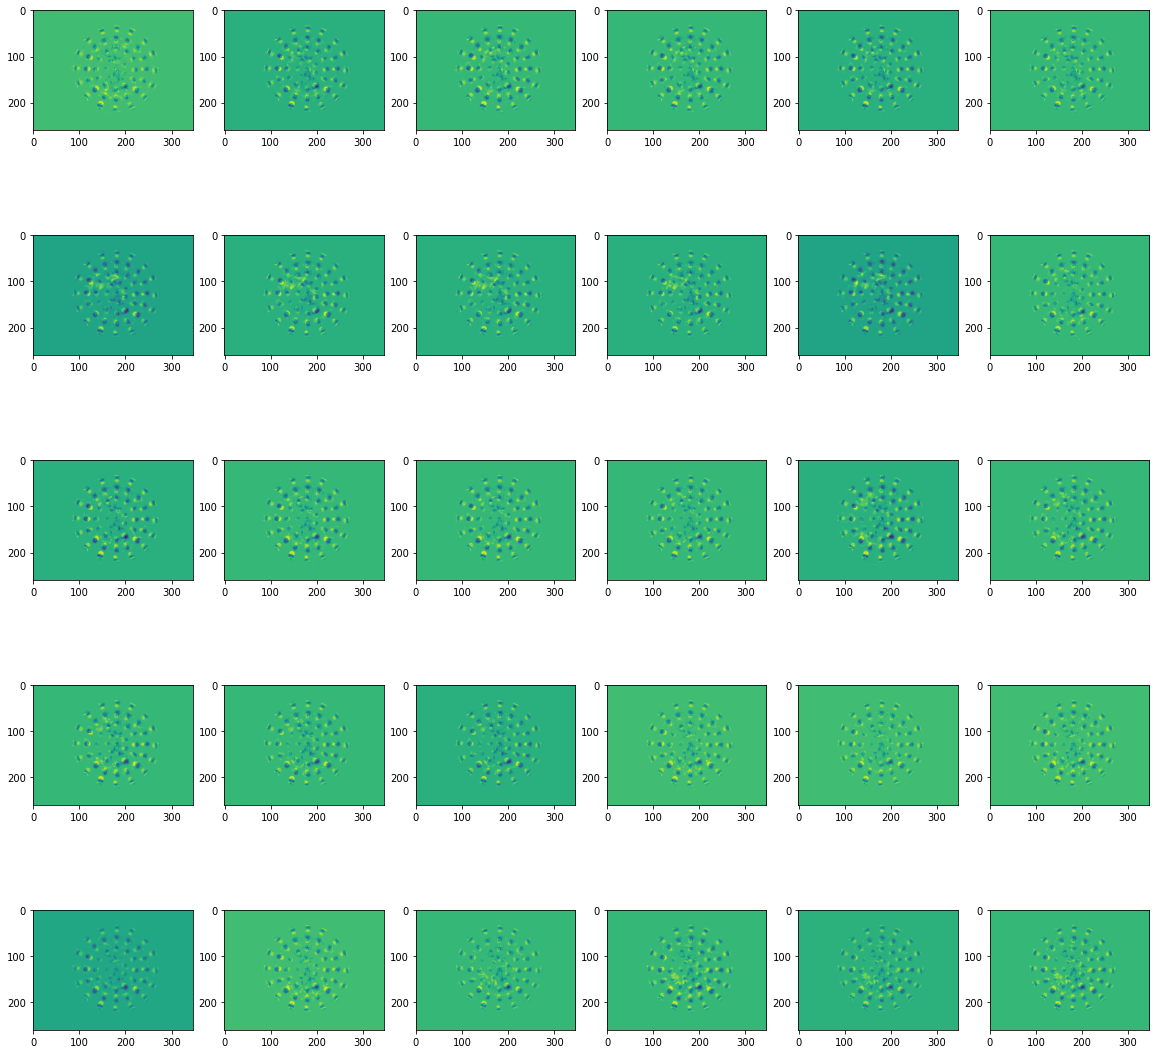

In [14]:
#visualize example
# plot the sample image
hf = h5py.File(h5_file_name, 'r+')
print(len(hf['event_images']))
fig=plt.figure(figsize=(20, 20))
rows = 5
columns = 6
for i in range(0, 30):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(hf['event_images'][i][:,:,2])
plt.show()
hf.close()

In [ ]:

# event_times = np.array([events[i][2] for i in range(np.shape(events)[0])])
# threshold = 10000
# plt.plot(event_times)
# plt.show()
# print(contact_case_ts_int[ contact_rise_idx[0] ])
# event_in_time_idx = np.where((event_times > (contact_case_ts_int[ contact_rise_idx[0] ] - 0.3)) * (event_times < contact_case_ts_int[ contact_rise_idx[0] ] ))
# print(len(event_in_time_idx))
# if len(event_in_time_idx) < threshold:
#     print("ok")
# else:
#     output_events = events[event_in_time_idx][:]
#     print("why")

In [15]:
del EventPreProcess
from importlib import reload  
import EventPreProcess
reload(EventPreProcess)
from EventPreProcess import EventPreProcess

In [16]:
#Generate frames, crop and and store in h5 file
#hf.close()
hf = h5py.File(h5_file_name, 'w')
hf.create_dataset('contact_status', data=contact_case_int)
hf.create_dataset('time_steps', data=contact_case_ts_int)

set_size = 1000
unprocessed_events = np.copy(events)
# print(len(contact_case_int))
# print(contact_case_ts_int)
# desired_status = 12
# encounter = np.min(np.nonzero([i == desired_status for i in hf['contact_status']]))#searches for the desired status
# print(encounter)

for i in range(0, len(contact_case_ts_int), set_size):
    start_idx=i
    end_idx=min([len(contact_case_ts_int), i+set_size])
    #[event_frames, unprocessed_events] = EventPreProcess.ConcatenateEvents(unprocessed_events, contact_case_ts_int[start_idx:end_idx])

    #[event_frames, unprocessed_events] = EventPreProcess.generateFrames_temporalROI(unprocessed_events, contact_case_ts_int[start_idx:end_idx])
    [event_frames, unprocessed_events] = EventPreProcess.generateFrames(unprocessed_events, contact_case_ts_int[start_idx:end_idx])
    
    #print("event frames shape : ", np.shape(event_frames))
    cropped_image = EventPreProcess.cropFrames(event_frames, circle_center=(170, 125), circle_rad=115)
    #print("length cropped iamges : ", len(cropped_image))
    
    #write data
    if i==0:
        hf.create_dataset('event_images', data=cropped_image, maxshape=(None,None, None, None))
    else:
        hf['event_images'].resize(len(hf['event_images']) + len(cropped_image), axis=0)
        hf["event_images"][-len(cropped_image):] = cropped_image 

    
    del event_frames

hf.close()

In [ ]:
# hf = h5py.File(h5_file_name, 'r+')
# desired_status = 13
# encounter = np.min(np.nonzero([i == desired_status for i in hf['contact_status']]))#searches for the desired status
# print(encounter)
# print("time of contact = ", (hf['time_steps'][encounter]/1e9))

# original_image = hf['event_images'][encounter]
# original_contact_status = hf['contact_status'][encounter]
# rot_90_image = EventPreProcess.rotateFrames([original_image], circle_center=(170, 125), rotate_angle=90)
# rot_90_contact_status = EventPreProcess.updateContactStatus([original_contact_status], list_of_rotations, 90)

# plt.imshow(original_image[:,:,0])
# plt.show()
# print(original_contact_status)
# print(rot_90_contact_status)
# plt.imshow(rot_90_image[0])
# plt.show()
# hf.close()

In [18]:
hf = h5py.File(h5_file_name, 'r+')
print(hf['contact_status'].shape)
print(hf['event_images'].shape)
hf.close()


(15241,)
(15241, 260, 346, 1)


In [19]:
def rotateFrames(image_list, circle_center=(173, 130), rotate_angle=90, im_height=260, im_width=346, expand_dims=False):
        
        rotated_image_list = []

        for image in image_list:
            rot_mat = cv2.getRotationMatrix2D(circle_center, rotate_angle, 1.0)
            #rotated_image = cv2.warpAffine(image[:,:,0], rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
            rotated_image = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)

            if expand_dims:
                rotated_image_list.append(np.expand_dims(np.copy(rotated_image), axis=2)) 
            else:
                rotated_image_list.append(np.copy(rotated_image))

        return rotated_image_list


In [195]:
hf.close()

In [23]:
#Augment images with rotation
hf = h5py.File(h5_file_name, 'r+')
set_size = 10

for i in range(0, len(hf['event_images']), set_size):
    start_idx=i
    end_idx=min([len(hf['event_images']), i+set_size])

    original_image = hf['event_images'][start_idx:end_idx]
    original_contact_status = hf['contact_status'][start_idx:end_idx]

    rot_90_image = rotateFrames(original_image, circle_center=(170, 125), rotate_angle=90, expand_dims=False)
    rot_90_contact_status = EventPreProcess.updateContactStatus(original_contact_status, list_of_rotations, 90)

    rot_180_image = rotateFrames(original_image, circle_center=(170, 125), rotate_angle=180, expand_dims=False)
    rot_180_contact_status = EventPreProcess.updateContactStatus(original_contact_status, list_of_rotations, 180)

    rot_270_image = rotateFrames(original_image, circle_center=(170, 125), rotate_angle=270, expand_dims=False)
    rot_270_contact_status = EventPreProcess.updateContactStatus(original_contact_status, list_of_rotations, 270)

    print(original_image.shape)
    print(len(rot_90_image)
    print(rot_90_image[1].shape)

    #write data
    if i==0:
        hf.create_dataset('event_images_augmented', data=np.concatenate((original_image, rot_90_image, rot_180_image, rot_270_image), axis=0), maxshape=(None,None, None, None))
        hf.create_dataset('contact_status_augmented', data=np.concatenate((original_contact_status, rot_90_contact_status, rot_180_contact_status, rot_270_contact_status), axis=0), maxshape=(None,))
    else:
        hf['event_images_augmented'].resize(len(hf['event_images_augmented']) + 4*len(original_image), axis=0)
        hf["event_images_augmented"][-4*len(original_image):] = np.concatenate((original_image, rot_90_image, rot_180_image, rot_270_image), axis=0)

        hf['contact_status_augmented'].resize(len(hf['contact_status_augmented']) + 4*len(original_contact_status), axis=0)
        hf["contact_status_augmented"][-4*len(original_contact_status):] = np.concatenate((original_contact_status, rot_90_contact_status, rot_180_contact_status, rot_270_contact_status), axis=0)

hf.close()

(10, 260, 346, 1)
(260, 346)


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 4 dimension(s) and the array at index 1 has 3 dimension(s)

In [198]:
hf.close()

In [21]:
print(np.array(list_of_rotations[2][0:2]))
rotation_angle = 90
rot_mat = np.array( [ [math.cos(rotation_angle*math.pi/180), math.sin(rotation_angle*math.pi/180)], [-math.sin(rotation_angle*math.pi/180), math.cos(rotation_angle*math.pi/180)] ] )
print(rot_mat)
print(np.matmul(rot_mat, list_of_rotations[2][0:2] ))

[0.10606602 0.10606602]
[[ 6.123234e-17  1.000000e+00]
 [-1.000000e+00  6.123234e-17]]
[ 0.10606602 -0.10606602]


In [22]:
hf = h5py.File(h5_file_name, 'r+')
print('number of event images: {}'.format(len(hf['contact_status_augmented'])))
hf.close()

number of event images: 316


In [23]:
hf = h5py.File(h5_file_name, 'r+')
n_classes = 18
for i in range(len(hf['contact_status_augmented'])):
    one_hot_vector = [0] * n_classes
    one_hot_vector[int(hf['contact_status_augmented'][i])] = 1
    if not ('ex_input_image_idx' in hf.keys()):
        hf.create_dataset('ex_input_image_idx', data=[i], maxshape=(None,))
        hf.create_dataset('ex_output', data=[one_hot_vector], maxshape=(None, None))
    else:
        hf['ex_input_image_idx'].resize(len(hf['ex_input_image_idx']) + 1, axis=0)
        hf["ex_input_image_idx"][len(hf['ex_input_image_idx'])-1] = i

        hf['ex_output'].resize(len(hf['ex_output']) + 1, axis=0)
        hf["ex_output"][len(hf['ex_output'])-1] = one_hot_vector

hf.close()

                

In [24]:
hf = h5py.File(h5_file_name, 'r+')
print(hf['ex_input_image_idx'].shape)
print(hf['ex_output'].shape)
hf.close()

(316,)
(316, 18)


20


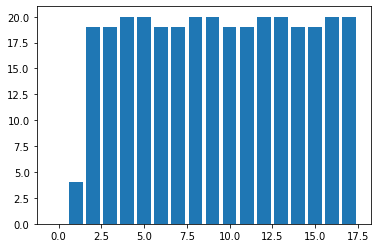

In [25]:
#analyze classes
hf = h5py.File(h5_file_name, 'r+')
counter = [0] * 18

for i in range(len(hf['ex_output'])):
    idx = list(hf['ex_output'][i]).index(1)
    counter[idx] = counter[idx] + 1

print(counter[17])
plt.bar(range(0,18),counter)#18),counter)
hf.close()

In [55]:
hf = h5py.File(h5_file_name, 'r+')
print(hf['ex_input_image_idx'].shape)
hf.close()

(340,)


In [26]:
#Equalize representation of classes (Just to match the names of the dataset with the older version)
hf = h5py.File(h5_file_name, 'r+')
hf.create_dataset('ex_input_image_idx_equalized', data=hf['ex_input_image_idx'])
hf.create_dataset('ex_output_equalized', data=hf['ex_output'])
hf.close()

316
[0, 4, 19, 19, 20, 20, 19, 19, 20, 20, 19, 19, 20, 20, 19, 19, 20, 20]


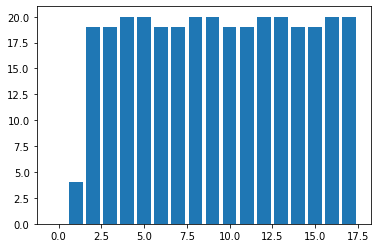

In [27]:
hf = h5py.File(h5_file_name, 'r+')
new_counter = [0] * 18
print(len(hf['ex_input_image_idx_equalized']))
for i in range(len(hf['ex_output_equalized'])):
    idx = list(hf['ex_output_equalized'][i]).index(1)
    new_counter[idx] = new_counter[idx] + 1

print(new_counter)
plt.bar(range(0,18),new_counter)
hf.close()

[4507, 4567, 4628, 4688, 4748]


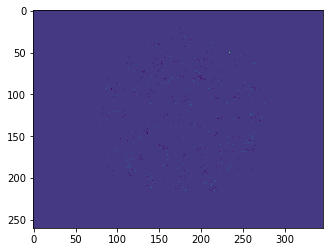

[1904, 1965, 5025, 5084, 5145, 10105, 10165, 10226, 10286, 10345, 15306, 15367, 15426, 15487, 15546, 16507, 16567, 16628, 16688, 16748]


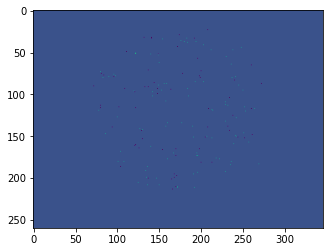

In [ ]:
#compare augmented data with regular images
hf = h5py.File(h5_file_name, 'r')
desired_class = 16
idx = 0
increment = 2

edge_locations = np.where(np.multiply(np.diff(hf['contact_status'])>0, np.equal(np.array(hf['contact_status']), desired_class * np.ones(shape=np.shape(hf['contact_status'])))[1:] ))
edge_locations = np.array(edge_locations)[0].tolist()
print(edge_locations)

plt.imshow(hf['event_images'][edge_locations[idx]+increment][:,:,0])
plt.show()

idx = 2

edge_locations_augmented = np.where(np.multiply(np.diff(hf['contact_status_augmented'])>0, np.equal(np.array(hf['contact_status_augmented']), desired_class * np.ones(shape=np.shape(hf['contact_status_augmented'])))[1:] ))
edge_locations_augmented = np.array(edge_locations_augmented)[0].tolist()
print(edge_locations_augmented)

plt.imshow(hf['event_images_augmented'][edge_locations_augmented[idx]+increment][:,:,0])
plt.show()

hf.close()

In [ ]:
hf = h5py.File(h5_file_name, 'r+')
del hf['ex_input_image_idx'] 
del hf['ex_output']
hf.close()

In [ ]:
print(np.mean(hf['event_images'][:,:,:,0]))
print(np.std(hf['event_images'][:,:,:,0]))
print(np.max(hf['event_images'][:,:,:,0]))
print(np.min(hf['event_images'][:,:,:,0]))


0.0008835273
0.031460017
21.0
0.0


(260, 346, 3)
4.0
-9.0


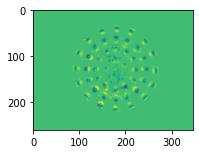

In [28]:
from PIL import Image
import h5py
import matplotlib.pylab as plt
import numpy as np
np.set_printoptions(threshold=np.inf)
h5_file_name = 'dataset_1_new.hdf5'
hf = h5py.File(h5_file_name, 'r')
print(hf['event_images_augmented'][0].shape)
fig=plt.figure(figsize=(20, 20))
rows = 5
columns = 6
for i in range(0, 1):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(hf['event_images_augmented'][0][:,:,2])
    
    #print(hf['event_images_augmented'][0][:,:,2])
    im = Image.fromarray(hf['event_images_augmented'][0][:,:,2])
    if im.mode != 'RGB':
        im = im.convert('RGB')
    print(np.max(hf['event_images_augmented'][0][:,:,2]))
    print(np.min(hf['event_images_augmented'][0][:,:,2]))
    im.save("preprocess_frame.png")
plt.show()
hf.close()